In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn.linear_model
import matplotlib.patches as mpatches

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, validation_curve, learning_curve
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score
from sklearn.model_selection import GridSearchCV

In [2]:
data = pd.read_csv("recruitmentdataset-2022-1.3.csv")

In [3]:
D_data = data[(data['company'] == 'D') & (data['sport'].isin(['Swimming', 'Football', 'Golf']))]
D_data = D_data.drop(columns=['company','Id'])
D_data.info()
D_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 474 entries, 3000 to 3999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   gender                 474 non-null    object
 1   age                    474 non-null    int64 
 2   nationality            474 non-null    object
 3   sport                  474 non-null    object
 4   ind-university_grade   474 non-null    int64 
 5   ind-debateclub         474 non-null    bool  
 6   ind-programming_exp    474 non-null    bool  
 7   ind-international_exp  474 non-null    bool  
 8   ind-entrepeneur_exp    474 non-null    bool  
 9   ind-languages          474 non-null    int64 
 10  ind-exact_study        474 non-null    bool  
 11  ind-degree             474 non-null    object
 12  decision               474 non-null    bool  
dtypes: bool(6), int64(3), object(4)
memory usage: 32.4+ KB


,gender,age,nationality,sport,ind-university_grade,ind-debateclub,ind-programming_exp,ind-international_exp,ind-entrepeneur_exp,ind-languages,ind-exact_study,ind-degree,decision
3000,female,28,Dutch,Golf,65,False,False,True,False,1,False,phd,True
3001,female,22,Dutch,Football,70,False,True,False,False,1,True,master,True
3004,female,21,Dutch,Football,66,False,False,False,True,2,False,bachelor,True
3005,female,25,Dutch,Swimming,68,False,True,False,False,0,True,master,False
3006,male,31,Dutch,Football,67,False,True,False,False,2,True,master,True


# Data exploration

In [4]:
sns.set_style("whitegrid")
colors = ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a", "#ffee65", "#beb9db", "#fdcce5", "#8bd3c7","#a57c1b"]
female_color = colors[7]
male_color = colors[1]
sns.set_palette(sns.color_palette(colors))

# hired_color = '#ffee65'
# unhired_color = '#beb9db'

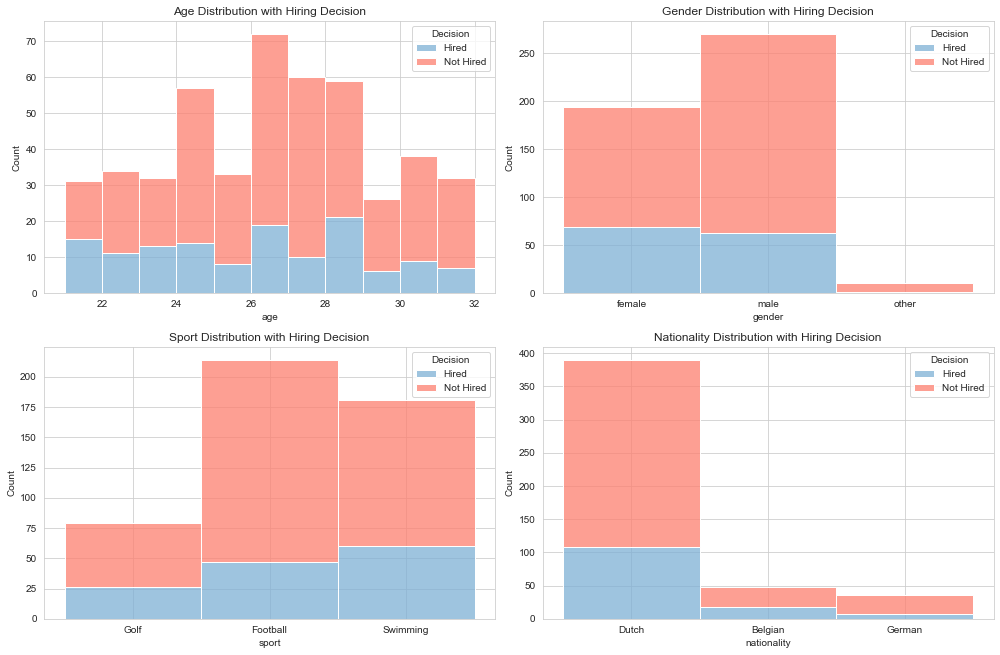

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Age distribution
sns.histplot(data=D_data, x='age', hue='decision', multiple="stack", ax=axes[0, 0])
axes[0, 0].set_title('Age Distribution with Hiring Decision')
axes[0, 0].legend(title='Decision', labels=['Hired', 'Not Hired'])
           
# gender distribution
sns.histplot(data=D_data, x='gender', hue='decision', multiple="stack", binwidth=1, ax=axes[0, 1])
axes[0, 1].set_title('Gender Distribution with Hiring Decision')
axes[0, 1].legend(title='Decision', labels=['Hired', 'Not Hired'])

# sport distribution
sns.histplot(data=D_data, x='sport',hue='decision', multiple="stack", bins=4, ax=axes[1, 0])
axes[1, 0].set_title('Sport Distribution with Hiring Decision')
axes[1, 0].legend(title='Decision', labels=['Hired', 'Not Hired'])

# Nationality Distribution
sns.histplot(data=D_data, x='nationality', hue='decision', multiple="stack", ax=axes[1, 1])
axes[1, 1].set_title('Nationality Distribution with Hiring Decision')
axes[1, 1].legend(title='Decision', labels=['Hired', 'Not Hired'])


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

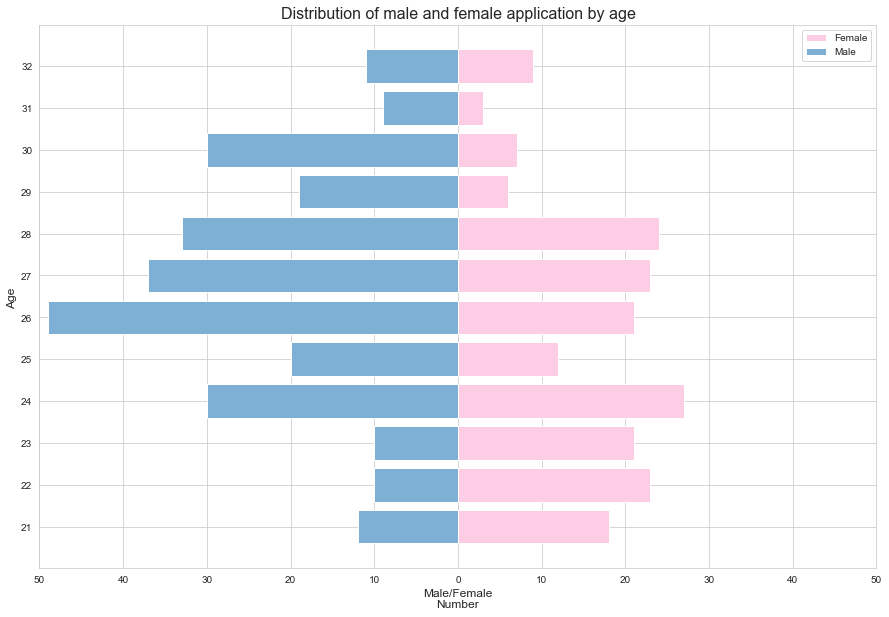

In [6]:
#AGE BY GENDER
age = [21, 22,23,24,25,26,27,28,29,30,31,32]
male = [0,0,0,0,0,0,0,0,0,0,0,0]
female = [0,0,0,0,0,0,0,0,0,0,0,0]

for i in age:
    for ind in D_data.index:
        if(i == D_data['age'][ind]):
            if (D_data['gender'][ind] == 'female'): female[i-21] +=1
            elif (D_data['gender'][ind] == 'male'): male[i-21] +=1


population_df = pd.DataFrame({"Age": age, "Male": male, "Female": female})
population_df["Female_Left"] = 0
population_df["Female_Width"] = population_df["Female"]
population_df["Male_Left"] = -population_df["Male"]
population_df["Male_Width"] = population_df["Male"]

fig = plt.figure(figsize=(15,10))

plt.barh(y=population_df["Age"], width=population_df["Female_Width"], color=female_color, label="Female");
plt.barh(y=population_df["Age"], width=population_df["Male_Width"], left=population_df["Male_Left"],
         color=male_color, label="Male")

ax1 = plt.subplot()
ax1.set_yticks(population_df["Age"])
plt.xticks(ticks=[-50, -40,-30,-20,-10, 0,10,20, 30,40 ,50],
labels=['50', '40', '30' ,'20','10', '0','10','20', '30','40', '50'])
plt.legend(loc="best");
plt.xlabel("Male/Female\nNumber", fontsize=12)
plt.ylabel("Age ",fontsize = 12)
plt.title("Distribution of male and female application by age", fontsize=16)
plt.show()

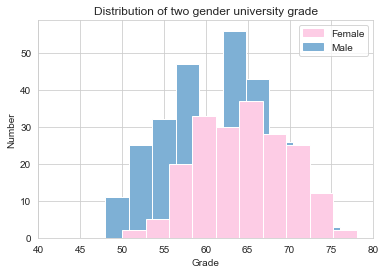

In [7]:
#Male vs female:
pink_patch = mpatches.Patch(color=female_color, label='Female')
blue_patch = mpatches.Patch(color=male_color, label='Male')

plt.hist(D_data[D_data['gender'] == 'male']['ind-university_grade'],  color = male_color)
plt.hist(D_data[D_data['gender'] == 'female']['ind-university_grade'],  color = female_color)

plt.title('Distribution of two gender university grade')
plt.xlabel('Grade')
plt.ylabel('Number')
plt.legend(handles=[pink_patch, blue_patch])
plt.xlim(left=40, right = 80)
plt.show()

I don't think this one is helpful, female bars covered male's.

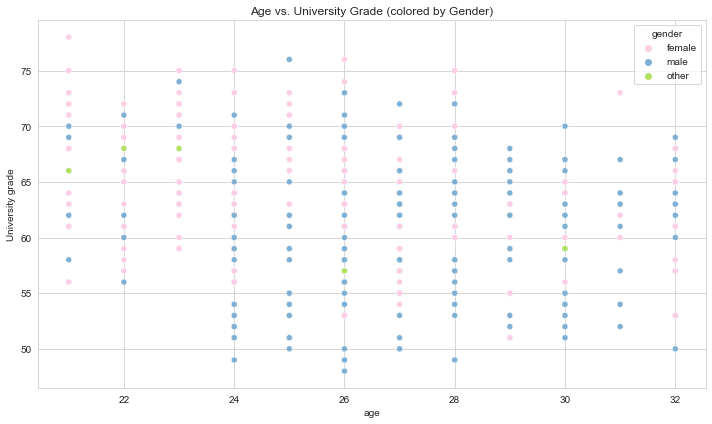

In [8]:
plt.figure(figsize=(10, 6))

sns.scatterplot(data=D_data, x='age', y='ind-university_grade', hue='gender', marker='o', palette=[female_color, male_color, '#b2e061'])
plt.title('Age vs. University Grade (colored by Gender)')
plt.ylabel('University grade')

plt.tight_layout()
plt.show()

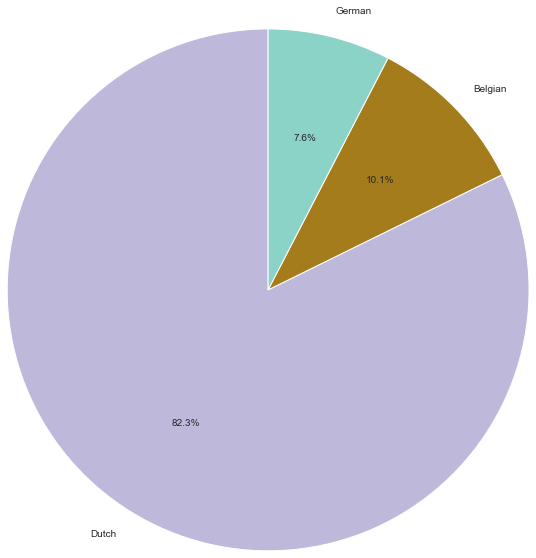

In [9]:
#Nationality ratio
country_count = D_data['nationality'].nunique()
country_count_series = D_data['nationality'].value_counts()
countries = []
count_country = []
for country, freq in country_count_series.iteritems():
        countries.append(country)
        count_country.append(freq)
plt.pie(count_country,labels=countries, startangle=90, autopct='%1.1f%%',radius=3, colors=["#beb9db","#a57c1b", "#8bd3c7"])
plt.show()

In [10]:
min_max_values = D_data.agg({
    'age': ['min', 'max'],
    'ind-university_grade': ['min', 'max'],
    'ind-languages': ['min', 'max']
})

min_max_values.rename(index={'min': 'Minimum', 'max': 'Maximum'}, inplace=True)
min_max_values.columns = ['Age', 'University Grade', 'Number of Languages']
min_max_values

,Age,University Grade,Number of Languages
Minimum,21,48,0
Maximum,32,78,3


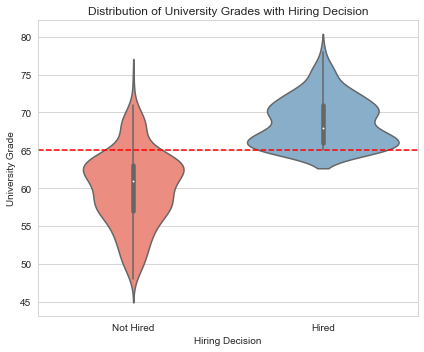

In [11]:
sns.set_palette(sns.color_palette(colors))
plt.figure(figsize=(6, 5))

sns.violinplot(data=D_data, x='decision', y='ind-university_grade')
plt.title('Distribution of University Grades with Hiring Decision')
plt.xlabel("Hiring Decision")
plt.ylabel("University Grade")
plt.xticks(ticks=[False, True], labels=['Not Hired', 'Hired'])
plt.axhline(y=65, color='r', linestyle='--', label='y=65')

plt.tight_layout()
plt.show()

- The median grade of hired candidates is visibly higher than that of non-hired candidates. The minimum grade requirement >=65 in relation to hiring decisions.

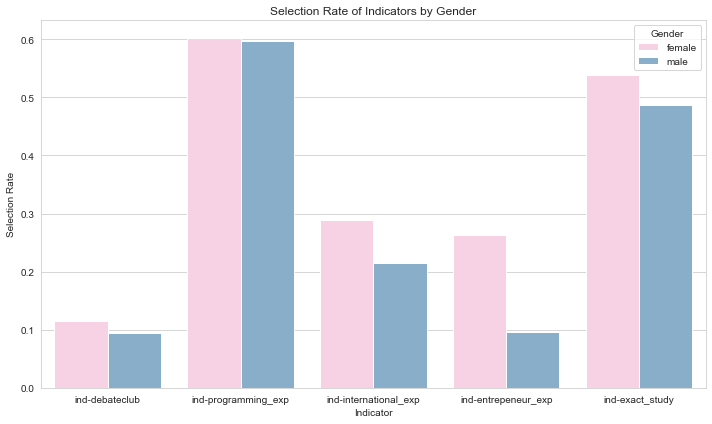

In [12]:
gender_data = D_data[D_data['gender'].isin(['female', 'male'])]

indicators = [
    'ind-debateclub',
    'ind-programming_exp',
    'ind-international_exp',
    'ind-entrepeneur_exp',
    'ind-exact_study'
]

# Calculate selection rates for each indicator and gender
selection_rates_gender = pd.DataFrame()

for ind in indicators:
    rates = gender_data[gender_data[ind] == True].groupby('gender')['decision'].mean().reset_index()
    rates['indicator'] = ind
    selection_rates_gender = pd.concat([selection_rates_gender, rates], axis=0)

plt.figure(figsize=(10, 6))
sns.barplot(data=selection_rates_gender, x='indicator', y='decision', hue='gender', palette= [female_color, male_color])
plt.title('Selection Rate of Indicators by Gender')
plt.xlabel('Indicator')
plt.ylabel('Selection Rate')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

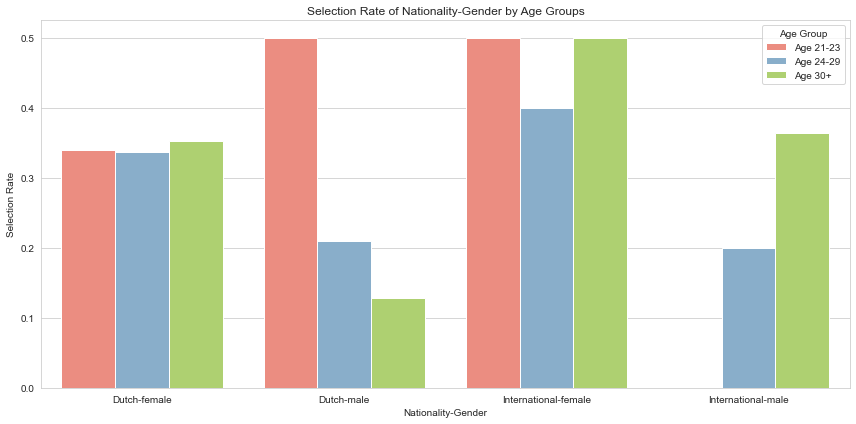

In [13]:
bins = [47, 64, 69, 100] 
labels = ['Grade 48-64', 'Grade 65-69', 'Grade 70+']
D_data['grade_group'] = pd.cut(D_data['ind-university_grade'], bins=bins, labels=labels, right=True)

bins = [20, 23, 29, 100]  
labels = ['Age 21-23', 'Age 24-29', 'Age 30+']
D_data['age_group'] = pd.cut(D_data['age'], bins=bins, labels=labels, right=True)

# Simplify nationality and filter data for specified genders
D_data['simple_nationality'] = D_data['nationality'].apply(lambda x: 'Dutch' if x == 'Dutch' else 'International')
filtered_data = D_data[D_data['gender'].isin(['female', 'male'])].copy()  # Creating a copy to avoid warnings

filtered_data['nationality_gender'] = filtered_data['simple_nationality'] + '-' + filtered_data['gender']

selection_rates_natgen_age = filtered_data.groupby(['nationality_gender', 'age_group'])['decision'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=selection_rates_natgen_age, x='nationality_gender', y='decision', hue='age_group', ci=None)
plt.title('Selection Rate of Nationality-Gender by Age Groups')
plt.xlabel('Nationality-Gender')
plt.ylabel('Selection Rate')
plt.legend(title='Age Group')
plt.tight_layout()
plt.show()

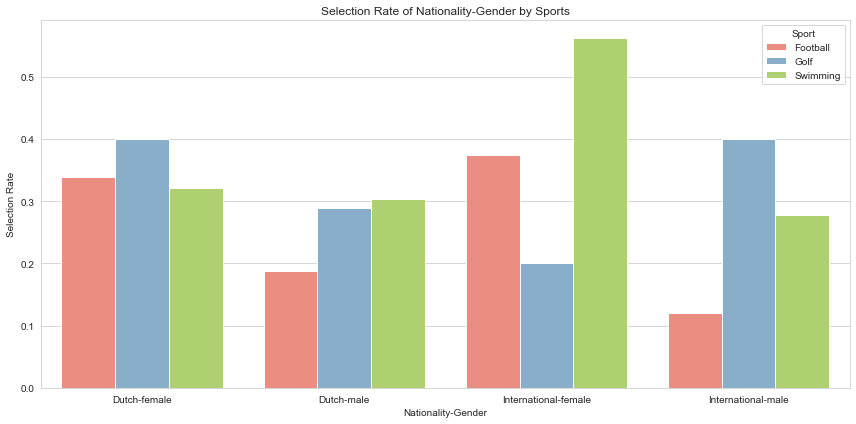

In [14]:
selection_rates_natgen_sport = filtered_data.groupby(['nationality_gender', 'sport'])['decision'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=selection_rates_natgen_sport, x='nationality_gender', y='decision', hue='sport', ci=None)
plt.title('Selection Rate of Nationality-Gender by Sports')
plt.xlabel('Nationality-Gender')
plt.ylabel('Selection Rate')
plt.legend(title='Sport')
plt.tight_layout()
plt.show()


## Comparison of Selection rates of Subgroups

In [15]:
filtered_data.head()

,gender,age,nationality,sport,ind-university_grade,ind-debateclub,ind-programming_exp,ind-international_exp,ind-entrepeneur_exp,ind-languages,ind-exact_study,ind-degree,decision,grade_group,age_group,simple_nationality,nationality_gender
3000,female,28,Dutch,Golf,65,False,False,True,False,1,False,phd,True,Grade 65-69,Age 24-29,Dutch,Dutch-female
3001,female,22,Dutch,Football,70,False,True,False,False,1,True,master,True,Grade 70+,Age 21-23,Dutch,Dutch-female
3004,female,21,Dutch,Football,66,False,False,False,True,2,False,bachelor,True,Grade 65-69,Age 21-23,Dutch,Dutch-female
3005,female,25,Dutch,Swimming,68,False,True,False,False,0,True,master,False,Grade 65-69,Age 24-29,Dutch,Dutch-female
3006,male,31,Dutch,Football,67,False,True,False,False,2,True,master,True,Grade 65-69,Age 30+,Dutch,Dutch-male


In [16]:
# Create subgroups
filtered_data['nationality_gender_prog'] = filtered_data['nationality_gender'] + '&' + filtered_data['ind-programming_exp'].apply(lambda x: 'programming' if x else 'non-programming')
filtered_data['nationality_gender_exact'] = filtered_data['nationality_gender'] + '&' + filtered_data['ind-exact_study'].apply(lambda x: 'exact study' if x else 'non-exact_study')
filtered_data['nationality_gender_grade'] = filtered_data['nationality_gender'] + '&' + filtered_data['grade_group'].astype(str)
filtered_data['nationality_gender_degree'] = filtered_data['nationality_gender']  + '&' + filtered_data['ind-degree'].astype(str)
filtered_data['nationality_gender_sport']  = filtered_data['nationality_gender']  + '&' + filtered_data['sport'].astype(str)

filtered_data['age_prog'] = filtered_data['age_group'].astype(str) + '&' + filtered_data['ind-programming_exp'].apply(lambda x: 'programming' if x else 'non-programming')
filtered_data['age_exact'] = filtered_data['age_group'].astype(str) + '&' + filtered_data['ind-exact_study'].apply(lambda x: 'exact study' if x else 'non-exact_study')
filtered_data['age_grade'] = filtered_data['age_group'].astype(str) + '&' + filtered_data['grade_group'].astype(str)
filtered_data['age_degree'] = filtered_data['age_group'].astype(str) + '&' + filtered_data['ind-degree'].astype(str)

filtered_data = filtered_data.drop(columns=['gender', 'age', 'nationality' ,'simple_nationality', 
                                            'ind-debateclub', 'ind-international_exp', 'ind-entrepeneur_exp'])
filtered_data.columns.tolist()

['sport',
 'ind-university_grade',
 'ind-programming_exp',
 'ind-languages',
 'ind-exact_study',
 'ind-degree',
 'decision',
 'grade_group',
 'age_group',
 'nationality_gender',
 'nationality_gender_prog',
 'nationality_gender_exact',
 'nationality_gender_grade',
 'nationality_gender_degree',
 'nationality_gender_sport',
 'age_prog',
 'age_exact',
 'age_grade',
 'age_degree']

### Selelction rates of subgroups

In [17]:
subgroup_list = [
    'nationality_gender', 
    'age_group',
    'sport'
]

simple_subgroup = pd.DataFrame(columns=['Subgroup', 'Total', 'Selected', 'Rate%'])

# Recalculate metrics for each subgroup
for subgroup in subgroup_list:
    # Group by the subgroup and calculate metrics
    subgroup_data = filtered_data.groupby(subgroup)['decision'].agg(['count', 'sum']).reset_index()
    subgroup_data['Rate%'] = round((subgroup_data['sum'] / subgroup_data['count'] * 100),2)
    
    subgroup_data.columns = ['Subgroup', 'Total', 'Selected', 'Rate%']
    
    simple_subgroup = pd.concat([simple_subgroup, subgroup_data], ignore_index=True)

simple_subgroup = simple_subgroup.sort_values(by=['Rate%'], ascending=False)

simple_subgroup.head(10)  


,Subgroup,Total,Selected,Rate%
2,International-female,29,13,44.83
4,Age 21-23,94,38,40.43
0,Dutch-female,165,56,33.94
8,Golf,78,26,33.33
9,Swimming,177,59,33.33
5,Age 24-29,301,78,25.91
1,Dutch-male,217,51,23.5
6,Age 30+,69,16,23.19
3,International-male,53,12,22.64
7,Football,209,47,22.49


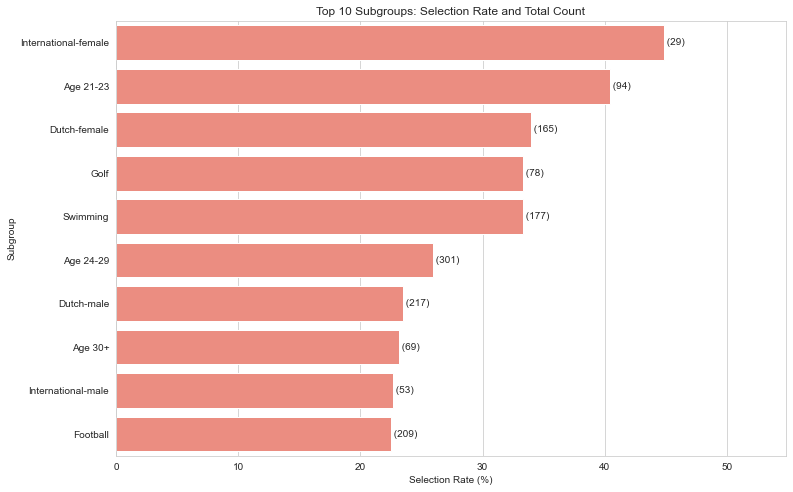

In [18]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Rate%', y='Subgroup', data=simple_subgroup.head(20), color=colors[0])

# Scatter plot for 'Total' values
for i, total in enumerate(simple_subgroup.head(20)['Total']):
    plt.text(simple_subgroup.head(10).iloc[i]['Rate%'], i, f" ({int(total)})", va='center')

plt.title('Top 10 Subgroups: Selection Rate and Total Count')
plt.xlabel('Selection Rate (%)')
plt.ylabel('Subgroup')
plt.xlim([0, simple_subgroup['Rate%'].max() + 10])  # Adjust limit to accommodate text

plt.show()



### Selelction rates of subgroups with indicators

In [19]:
subgroup_list = [
    'nationality_gender_prog', 
    'nationality_gender_exact', 
    'nationality_gender_grade', 
    'nationality_gender_degree', 
    'nationality_gender_sport',
    'age_prog',
    'age_exact',
    'age_grade',
    'age_degree'
]

subgroup_summary_corrected = pd.DataFrame(columns=['Subgroup', 'Total', 'Selected', 'Rate%'])

# Recalculate metrics for each subgroup
for subgroup in subgroup_list:
    # Group by the subgroup and calculate metrics
    subgroup_data = filtered_data.groupby(subgroup)['decision'].agg(['count', 'sum']).reset_index()
    subgroup_data['Rate%'] = round((subgroup_data['sum'] / subgroup_data['count'] * 100),2)
    
    subgroup_data.columns = ['Subgroup', 'Total', 'Selected', 'Rate%']
    
    subgroup_summary_corrected = pd.concat([subgroup_summary_corrected, subgroup_data], ignore_index=True)

subgroup_summary_corrected = subgroup_summary_corrected.sort_values(by=['Rate%'], ascending=False)

subgroup_summary_corrected.head(20)  


,Subgroup,Total,Selected,Rate%
27,International-male&Grade 70+,3,3,100.0
75,Age 21-23&phd,2,2,100.0
72,Age 30+&Grade 70+,4,4,100.0
24,International-female&Grade 70+,7,7,100.0
66,Age 21-23&Grade 70+,29,27,93.1
18,Dutch-female&Grade 70+,32,29,90.62
69,Age 24-29&Grade 70+,30,26,86.67
71,Age 30+&Grade 65-69,14,12,85.71
21,Dutch-male&Grade 70+,21,18,85.71
5,International-female&programming,15,12,80.0


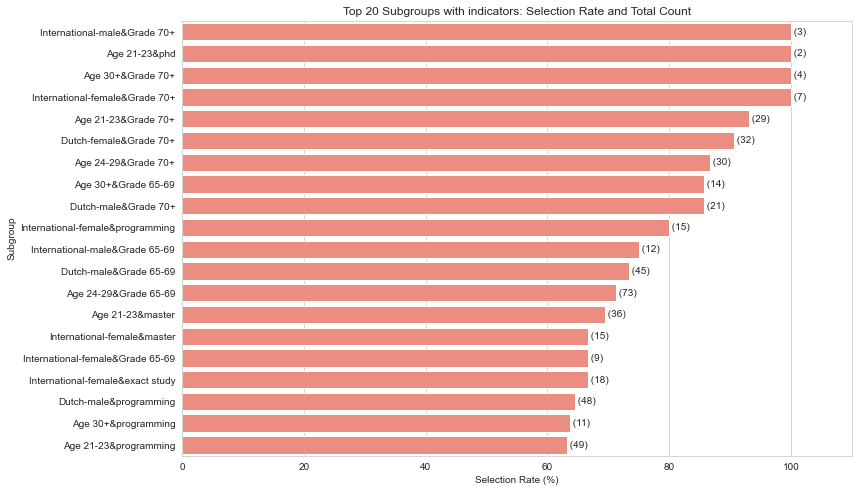

In [20]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Rate%', y='Subgroup', data=subgroup_summary_corrected.head(20), color=colors[0])

# Scatter plot for 'Total' values
for i, total in enumerate(subgroup_summary_corrected.head(20)['Total']):
    plt.text(subgroup_summary_corrected.head(20).iloc[i]['Rate%'], i, f" ({int(total)})", va='center')

plt.title('Top 20 Subgroups with indicators: Selection Rate and Total Count')
plt.xlabel('Selection Rate (%)')
plt.ylabel('Subgroup')
plt.xlim([0, subgroup_summary_corrected['Rate%'].max() + 10])  # Adjust limit to accommodate text

plt.show()



# Model

- Model 1: Descriptors Only
- Model 2: Indicators Only
- Model 3: Descriptors with One Indicator
- Model 4: One Indicator without Descriptors


In [21]:

# Using get_dummies for One-Hot Encoding and keeping original column names
D_data_encoded = pd.get_dummies(D_data, columns=['gender', 'nationality', 'sport'], prefix=['', '', ''], prefix_sep='')

# Integer Encoding for 'ind-degree' column
degree_mapping = {'bachelor': 0, 'master': 1, 'phd': 2}
D_data_encoded['ind-degree'] = D_data_encoded['ind-degree'].map(degree_mapping)

D_data_encoded = D_data_encoded.drop(columns=['age_group', 'grade_group', 'simple_nationality' , 'ind-debateclub', 'ind-international_exp', 'ind-entrepeneur_exp'])


D_data_encoded.head()
D_data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 474 entries, 3000 to 3999
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   age                   474 non-null    int64
 1   ind-university_grade  474 non-null    int64
 2   ind-programming_exp   474 non-null    bool 
 3   ind-languages         474 non-null    int64
 4   ind-exact_study       474 non-null    bool 
 5   ind-degree            474 non-null    int64
 6   decision              474 non-null    bool 
 7   female                474 non-null    uint8
 8   male                  474 non-null    uint8
 9   other                 474 non-null    uint8
 10  Belgian               474 non-null    uint8
 11  Dutch                 474 non-null    uint8
 12  German                474 non-null    uint8
 13  Football              474 non-null    uint8
 14  Golf                  474 non-null    uint8
 15  Swimming              474 non-null    uint8
dtypes: b

In [22]:
D_data_encoded.columns.tolist()

['age',
 'ind-university_grade',
 'ind-programming_exp',
 'ind-languages',
 'ind-exact_study',
 'ind-degree',
 'decision',
 'female',
 'male',
 'other',
 'Belgian',
 'Dutch',
 'German',
 'Football',
 'Golf',
 'Swimming']

In [23]:
X = D_data_encoded[['ind-university_grade', 'ind-languages']]

# X = D_data_encoded.drop(columns=['decision', 'ind-university_grade', 'ind-programming_exp',
#                                  'ind-languages', 'ind-exact_study', 'ind-degree',])
y = D_data_encoded['decision']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state = 42,
                                                    stratify=y)

param_grid = {
    'max_depth': np.arange(2, 18, 1),
    'min_samples_split': np.arange(2, 18, 1),
    'min_samples_leaf': np.arange(2, 18, 1)
}

tree_clf = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(estimator=tree_clf, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)
print(grid_search.best_score_)

DecisionTreeClassifier(max_depth=2, min_samples_leaf=2, random_state=42)
0.9013842961211382


In [24]:
color_rank = [ '#0072a0', '#00abf0', '#19bdff', '#37c6ff', '#55ceff', '#73d7ff', '#91e0ff','#a5e5ff','#b9ebff', '#cdf0ff']
def plot_top_features(model, feature_names, top_n, title):

    feature_importance = model.feature_importances_
    
    sorted_indices = np.argsort(feature_importance)[::-1]
    sorted_importance = feature_importance[sorted_indices]
    sorted_feature_names = feature_names[sorted_indices]
    
    # Select the top N most important features
    top_importance = sorted_importance[:top_n]
    top_feature_names = sorted_feature_names[:top_n]
    
    plt.barh(range(len(top_importance)), top_importance, align='center', color=color_rank)
    plt.yticks(range(len(top_importance)), top_feature_names)
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.title(title)
    plt.gca().invert_yaxis() 


In [25]:
# Create a DataFrame to store model validation scores
model_scores_df = pd.DataFrame(columns=['model', 'validation F1 score'])

## Model 1: Descriptors Only

In [26]:
## Hyperparameter tuning
X = D_data_encoded.drop(columns=['decision', 'ind-university_grade', 'ind-programming_exp',
                                  'ind-languages', 'ind-exact_study', 'ind-degree',])
y = D_data_encoded['decision']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state = 42,
                                                    stratify=y)

param_grid = {
    'max_depth': np.arange(2, 15, 1),
    'min_samples_split': np.arange(2, 15, 1),
    'min_samples_leaf': np.arange(2, 15, 1),
    'max_leaf_nodes': np.arange(2, 10, 1)
}

tree_clf = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(estimator=tree_clf, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)
print(grid_search.best_score_)


model_name = 'Model 1: all descriptors' 
new_row = pd.DataFrame({'model': [model_name], 'validation F1 score': [grid_search.best_score_]})
model_scores_df = pd.concat([model_scores_df, new_row], ignore_index=True)


DecisionTreeClassifier(max_depth=6, max_leaf_nodes=9, min_samples_leaf=4,
                       random_state=42)
0.28306227106227105


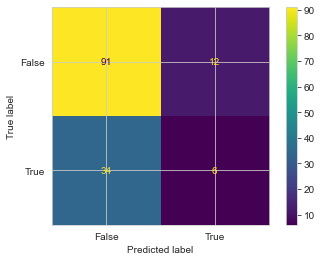

              precision    recall  f1-score   support

       False       0.73      0.88      0.80       103
        True       0.33      0.15      0.21        40

    accuracy                           0.68       143
   macro avg       0.53      0.52      0.50       143
weighted avg       0.62      0.68      0.63       143



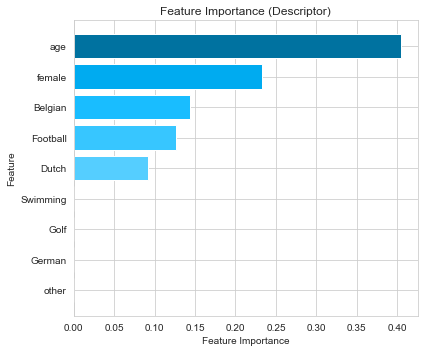

In [27]:
X = D_data_encoded.drop(columns=['decision', 'ind-university_grade', 'ind-programming_exp',
                                 'ind-languages', 'ind-exact_study', 'ind-degree',])
y = D_data_encoded['decision']

X_train_one, X_test_one, y_train_one, y_test_one = train_test_split(X, y, test_size=.3, random_state = 42,
                                                    stratify=y)

model_one = DecisionTreeClassifier(max_depth=6, max_leaf_nodes=9, min_samples_leaf=4,
                       random_state=42)

model_one.fit(X_train_one, y_train_one)
predictions = model_one.predict(X_test_one) 
confusion_matrix = sklearn.metrics.confusion_matrix(y_test_one, predictions)
cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()
print(classification_report(y_test_one, predictions))

plt.figure(figsize=(6, 5))

plot_top_features(model_one, X_train_one.columns, top_n=9, title="Feature Importance (Descriptor)")

plt.tight_layout()
plt.show()

## Model 2: 3 indicators Grade, languages, degree

In [28]:
## Hyperparameter tuning
X = D_data_encoded[['ind-university_grade', 'ind-languages', 'ind-degree']]
y = D_data_encoded['decision']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state = 42,
                                                    stratify=y)

param_grid = {
    'max_depth': np.arange(2, 15, 1),
    'min_samples_split': np.arange(2, 15, 1),
    'min_samples_leaf': np.arange(2, 15, 1),
    'max_leaf_nodes': np.arange(2, 10, 1)
}

tree_clf = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(estimator=tree_clf, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)
print(grid_search.best_score_)

model_name = 'Model 2: 3 indicators' 
new_row = pd.DataFrame({'model': [model_name], 'validation F1 score': [grid_search.best_score_]})
model_scores_df = pd.concat([model_scores_df, new_row], ignore_index=True)

DecisionTreeClassifier(max_depth=6, max_leaf_nodes=7, min_samples_leaf=2,
                       min_samples_split=14, random_state=42)
0.9138720785704096


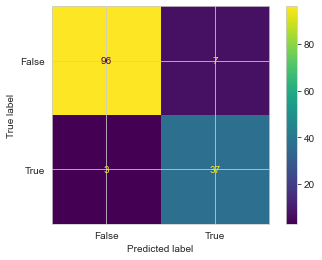

              precision    recall  f1-score   support

       False       0.97      0.93      0.95       103
        True       0.84      0.93      0.88        40

    accuracy                           0.93       143
   macro avg       0.91      0.93      0.92       143
weighted avg       0.93      0.93      0.93       143



In [29]:
X = D_data_encoded[['ind-university_grade', 'ind-languages', 'ind-degree']]
y = D_data_encoded['decision']

X_train_two, X_test_two, y_train_two, y_test_two = train_test_split(X, y, test_size=.3, random_state = 42,
                                                    stratify=y)

model_two = DecisionTreeClassifier(max_depth=6, max_leaf_nodes=7, min_samples_leaf=2,
                       min_samples_split=14, random_state=42)

model_two.fit(X_train_two, y_train_two)
predictions = model_two.predict(X_test_two) 
confusion_matrix = sklearn.metrics.confusion_matrix(y_test_one, predictions)
cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()
print(classification_report(y_test_two, predictions))

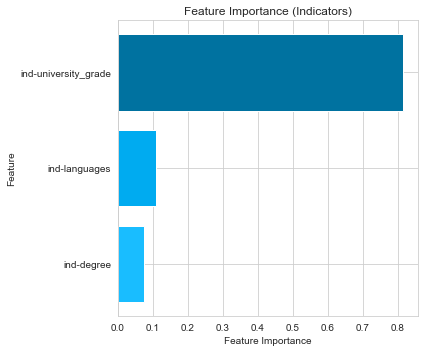

In [30]:
plt.figure(figsize=(6, 5))

plot_top_features(model_two, X_train_two.columns, top_n=3, title="Feature Importance (Indicators)")

plt.tight_layout()
plt.show()


 ## Model 3: 2 indicators Grade, languages

In [31]:
## Hyperparameter tuning
X = D_data_encoded[['ind-university_grade', 'ind-languages']]
y = D_data_encoded['decision']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state = 42,
                                                    stratify=y)

param_grid = {
    'max_depth': np.arange(2, 15, 1),
    'min_samples_split': np.arange(2, 15, 1),
    'min_samples_leaf': np.arange(2, 15, 1),
    'max_leaf_nodes': np.arange(2, 10, 1)
}

tree_clf = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(estimator=tree_clf, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)
print(grid_search.best_score_)

model_name = 'Model 3: 2 indicators' 
new_row = pd.DataFrame({'model': [model_name], 'validation F1 score': [grid_search.best_score_]})
model_scores_df = pd.concat([model_scores_df, new_row], ignore_index=True)

DecisionTreeClassifier(max_depth=2, max_leaf_nodes=3, min_samples_leaf=2,
                       random_state=42)
0.9013842961211382


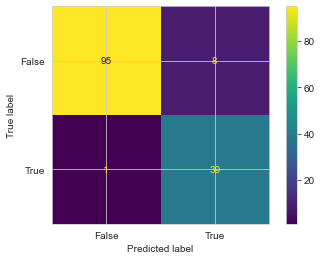

              precision    recall  f1-score   support

       False       0.99      0.92      0.95       103
        True       0.83      0.97      0.90        40

    accuracy                           0.94       143
   macro avg       0.91      0.95      0.93       143
weighted avg       0.94      0.94      0.94       143



In [32]:
X = D_data_encoded[['ind-university_grade', 'ind-languages']]
y = D_data_encoded['decision']

X_train_three, X_test_three, y_train_three, y_test_three = train_test_split(X, y, test_size=.3, random_state = 42,
                                                    stratify=y)

model_three = DecisionTreeClassifier(max_depth=2, max_leaf_nodes=3, min_samples_leaf=2,
                       random_state=42)

model_three.fit(X_train_three, y_train_three)
predictions = model_three.predict(X_test_three) 
confusion_matrix = sklearn.metrics.confusion_matrix(y_test_one, predictions)
cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()
print(classification_report(y_test_three, predictions))

## Model 4: 1 Indicator Grade

In [33]:
## Hyperparameter tuning
X = D_data_encoded[['ind-university_grade']]
y = D_data_encoded['decision']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state = 42,
                                                    stratify=y)

param_grid = {
    'max_depth': np.arange(2, 15, 1),
    'min_samples_split': np.arange(2, 15, 1),
    'min_samples_leaf': np.arange(2, 15, 1),
    'max_leaf_nodes': np.arange(2, 10, 1)
}

tree_clf = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(estimator=tree_clf, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)
print(grid_search.best_score_)

model_name = 'Model 4: 1 indicator' 
new_row = pd.DataFrame({'model': [model_name], 'validation F1 score': [grid_search.best_score_]})
model_scores_df = pd.concat([model_scores_df, new_row], ignore_index=True)

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=4, min_samples_leaf=2,
                       random_state=42)
0.8785353284741291


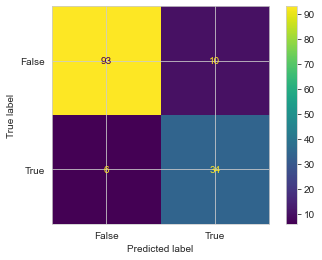

              precision    recall  f1-score   support

       False       0.94      0.90      0.92       103
        True       0.77      0.85      0.81        40

    accuracy                           0.89       143
   macro avg       0.86      0.88      0.87       143
weighted avg       0.89      0.89      0.89       143



In [34]:
X = D_data_encoded[['ind-university_grade']]
y = D_data_encoded['decision']

X_train_four, X_test_four, y_train_four, y_test_four = train_test_split(X, y, test_size=.3, random_state = 42,
                                                    stratify=y)

model_four = DecisionTreeClassifier(max_depth=3, max_leaf_nodes=4, min_samples_leaf=2,
                       random_state=42)

model_four.fit(X_train_four, y_train_four)
predictions = model_four.predict(X_test_four) 
confusion_matrix = sklearn.metrics.confusion_matrix(y_test_one, predictions)
cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()
print(classification_report(y_test_four, predictions))

## Model 5: Descriptors with One Indicator Grade

In [35]:
## Hyperparameter tuning
X = D_data_encoded.drop(columns=['decision', 'ind-programming_exp',
              'ind-languages', 'ind-exact_study', 'ind-degree'])
y = D_data_encoded['decision']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state = 42,
                                                    stratify=y)

param_grid = {
    'max_depth': np.arange(2, 15, 1),
    'min_samples_split': np.arange(2, 15, 1),
    'min_samples_leaf': np.arange(2, 15, 1),
    'max_leaf_nodes': np.arange(2, 10, 1)
}

tree_clf = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(estimator=tree_clf, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)
print(grid_search.best_score_)

model_name = 'Model 5: all descriptors with 1 indicator' 
new_row = pd.DataFrame({'model': [model_name], 'validation F1 score': [grid_search.best_score_]})
model_scores_df = pd.concat([model_scores_df, new_row], ignore_index=True)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=9, min_samples_leaf=4,
                       random_state=42)
0.8837004193443164


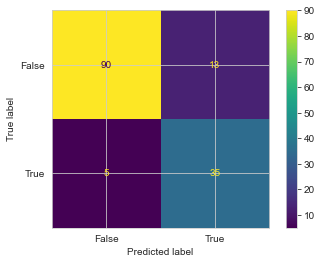

              precision    recall  f1-score   support

       False       0.95      0.87      0.91       103
        True       0.73      0.88      0.80        40

    accuracy                           0.87       143
   macro avg       0.84      0.87      0.85       143
weighted avg       0.89      0.87      0.88       143



In [36]:
X = D_data_encoded.drop(columns=['decision', 'ind-programming_exp',
              'ind-languages', 'ind-exact_study', 'ind-degree'])
y = D_data_encoded['decision']

X_train_five, X_test_five, y_train_five, y_test_five = train_test_split(X, y, test_size=.3, random_state = 42,
                                                    stratify=y)

model_five = DecisionTreeClassifier(max_depth=5, max_leaf_nodes=9, min_samples_leaf=4,
                       random_state=42)

model_five.fit(X_train_five, y_train_five)
predictions = model_five.predict(X_test_five) 
confusion_matrix = sklearn.metrics.confusion_matrix(y_test_one, predictions)
cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()
print(classification_report(y_test_five, predictions))

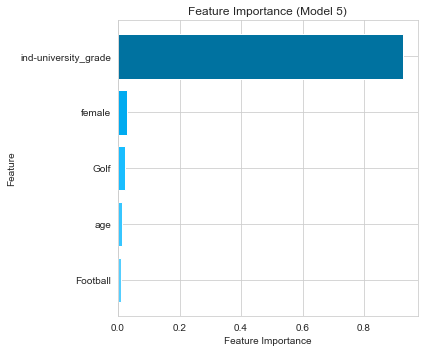

In [37]:
plt.figure(figsize=(6, 5))

plot_top_features(model_five, X_train_five.columns, top_n=5, title="Feature Importance (Model 5)")
plt.tight_layout()
plt.show()

## Model validation

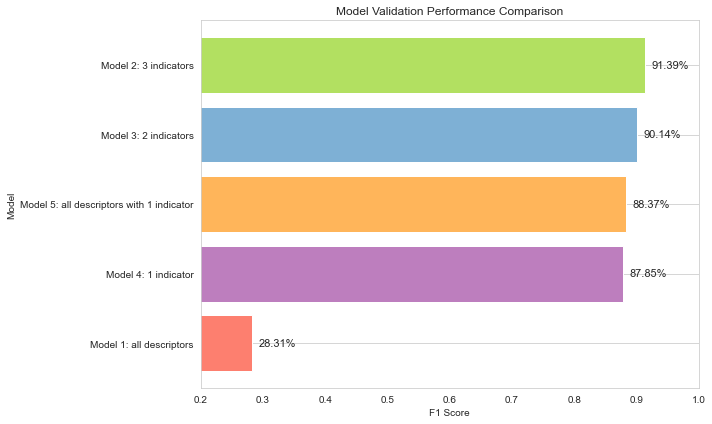

In [38]:
model_scores_df = model_scores_df.sort_values(by='validation F1 score', ascending=True)

plt.figure(figsize=(10, 6))
bars = plt.barh(model_scores_df['model'], model_scores_df['validation F1 score'], color=[colors[0], colors[3],colors[4], colors[1], colors[2]])

for bar in bars:
    plt.text(bar.get_width() + 0.01, 
             bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width()*100:.2f}%', 
             va='center', ha='left', 
             fontsize=11)

plt.xlabel('F1 Score')
plt.ylabel('Model')
plt.title('Model Validation Performance Comparison')
plt.xlim(0.2, 1) 
plt.grid(axis='x')

plt.tight_layout()
plt.show()

## Performance on test set

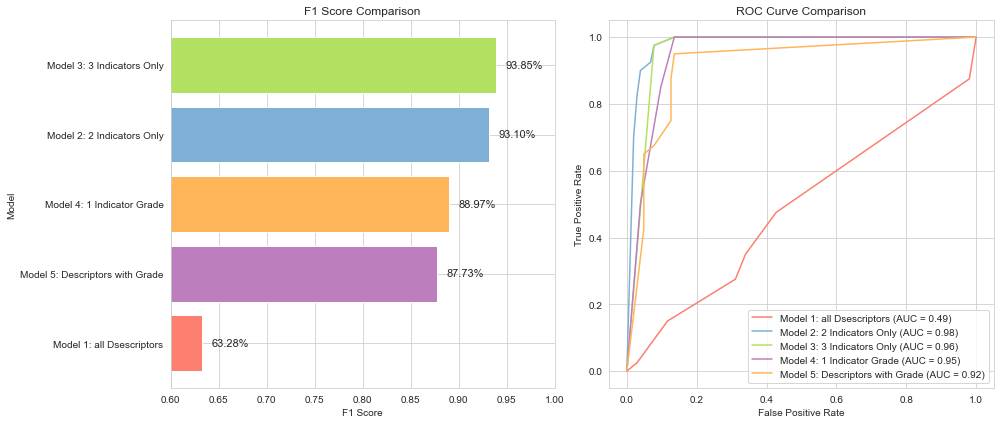

In [41]:
metrics = []

def calculate_metrics(model, X_test, y_test, model_name):
    predictions = model.predict(X_test)
    predict_proba = model.predict_proba(X_test)[:, 1]
    f1 = f1_score(y_test, predictions, average='weighted')
    fpr, tpr, _ = roc_curve(y_test, predict_proba)
    roc_auc = auc(fpr, tpr)
    metrics.append((model_name, f1, fpr, tpr, roc_auc))

calculate_metrics(model_one, X_test_one, y_test_one, "Model 1: all Dsescriptors")
calculate_metrics(model_two, X_test_two, y_test_two, "Model 2: 2 Indicators Only")
calculate_metrics(model_three, X_test_three, y_test_three, "Model 3: 3 Indicators Only")
calculate_metrics(model_four, X_test_four, y_test_four, "Model 4: 1 Indicator Grade")
calculate_metrics(model_five, X_test_five, y_test_five, "Model 5: Descriptors with Grade")
#calculate_metrics(model_six, X_test_six, y_test_six, "Model 6: 1 Descriptor with 2 Indicators")

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sorted_metrics = sorted(metrics, key=lambda x: x[1])

# Horizontal Bar Chart for F1-Score
bars = ax[0].barh([m[0] for m in sorted_metrics], [m[1] for m in sorted_metrics], color=[colors[0], colors[3],colors[4], colors[1], colors[2]])
ax[0].set_ylabel('Model')
ax[0].set_xlabel('F1 Score')
ax[0].set_xlim(0.6, 1.0)  # Adjusted to give a bit more space for the text
ax[0].set_title('F1 Score Comparison')

# Adding the score beside the bars
for bar, metric in zip(bars, sorted_metrics):
    ax[0].text(bar.get_width() + 0.01,  # X position, slightly beside the bar
               bar.get_y() + bar.get_height() / 2,  # Y position, centered
               f'{bar.get_width()*100:.2f}%',  # Text, formatted to two decimal places
               va='center',  # Vertical alignment is centered
               fontsize=11)

# ROC Curves
for m in metrics:
    ax[1].plot(m[2], m[3], label=f'{m[0]} (AUC = {m[4]:.2f})')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('ROC Curve Comparison')

ax[1].legend(loc='lower right')

plt.tight_layout()
plt.show()


## Hyperparameter tuning Performance Comparison

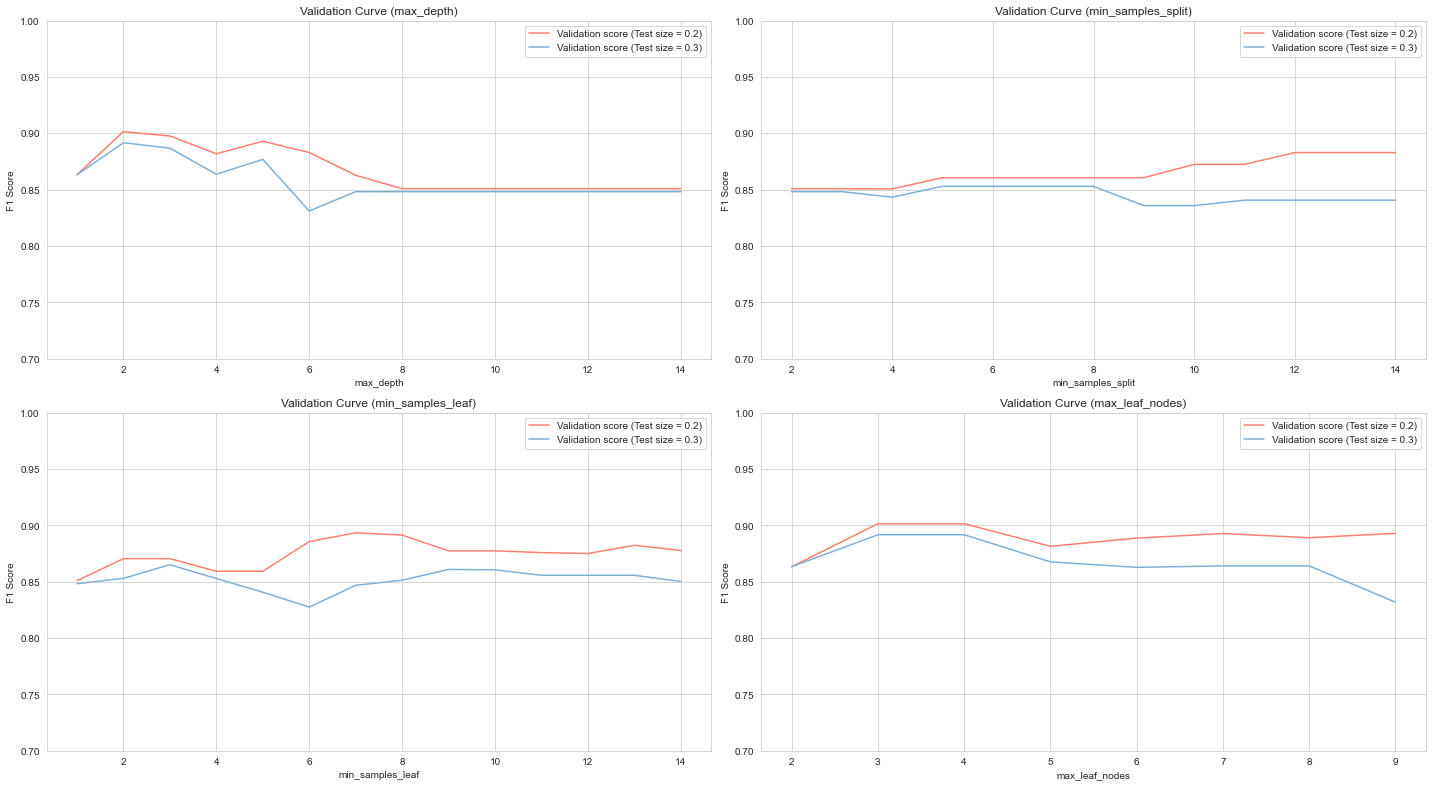

In [42]:
# model  
X = D_data_encoded[['ind-university_grade', 'ind-languages']]
y = D_data_encoded['decision']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_03, X_valid_03, y_train_03, y_valid_03 = train_test_split(X, y, test_size=0.3, random_state=42)

# Define new hyperparameter ranges
param_ranges = {
    'max_depth': np.arange(1, 15, 1),
    'min_samples_split': np.arange(2, 15, 1),
    'min_samples_leaf': np.arange(1, 15, 1),
    'max_leaf_nodes': np.arange(2, 10, 1)
}

fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Flatten the axes array to iterate through it
axes = axes.flatten()

# Iterate through hyperparameters and plot validation curves
for i, (param_name, param_range) in enumerate(param_ranges.items()):
    ax = axes[i]
    
    for test_size, X_t, y_t, label in zip(
        [0.2, 0.3], 
        [X_train, X_train_03], 
        [y_train, y_train_03], 
        ["Test size = 0.2", "Test size = 0.3"]
    ):
        _, valid_scores = validation_curve(
            DecisionTreeClassifier(random_state=42), 
            X_t, y_t, 
            param_name=param_name, param_range=param_range, 
            cv=5, scoring='f1', n_jobs=-1
        )

        valid_mean = np.mean(valid_scores, axis=1)

        # Plot validation curve
        ax.plot(param_range, valid_mean, label=f"Validation score ({label})")
    
    
    ax.set_title(f'Validation Curve ({param_name})')
    ax.set_xlabel(f'{param_name}')
    ax.set_ylabel('F1 Score')
    ax.set_ylim(0.7, 1) 
    ax.legend(loc="best")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Final model exploration